In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from networkx.algorithms.community import greedy_modularity_communities
from tabulate import tabulate
from operator import itemgetter

## Import the edge list from tsv

In [2]:
tsv_file_path = "soc-redditHyperlinks-body.tsv"

G = nx.DiGraph()

# Read the TSV file and add nodes and edges to the graph
with open(tsv_file_path, 'r') as file:
    # Skip the header line
    next(file)
    for line in file:
        # Split the line by tab
        data = line.strip().split('\t')
        if len(data) == 6:
            source_subreddit, target_subreddit, _, _, _, _ = data
            # Add source and target nodes to the graph if they don't exist
            if source_subreddit not in G:
                G.add_node(source_subreddit)
            if target_subreddit not in G:
                G.add_node(target_subreddit)
            # Add directed edge from source to target
            G.add_edge(source_subreddit, target_subreddit)


## Reduce the main graph and print some basic information

In [3]:
def reduce_graph(graph, perc_to_keep):

    # Calculate PageRank
    pagerank = nx.pagerank(graph)

    # Combine centrality measures
    pagerank_scores = {node: pagerank[node] for node in graph}

    # Sort nodes by combined score
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)

    # Select a fraction of nodes to keep (e.g., top 50%)
    num_nodes_to_keep = int(len(sorted_nodes) * perc_to_keep)
    nodes_to_keep = sorted_nodes[:num_nodes_to_keep]

    # Create a new graph with only selected nodes
    reduced_graph = graph.subgraph(nodes_to_keep)

    return reduced_graph

In [4]:
# Extract the biggest stronly connected component of the Graph
giant_component = max(nx.strongly_connected_components(G), key=len)
G_strong = G.subgraph(giant_component)

# Reduce graph size based on page ranking
G_small = reduce_graph(G_strong, 0.4)  # Adjust the threshold as needed

# Make the graph undirected
G_un = G_small.to_undirected()

In [5]:
print("Number of Nodes: ", G_un.number_of_nodes())
print("Number of Edges: ", G_un.number_of_edges())

# Average Node Degree
average_node_degree = np.mean([d for n, d in G_un.degree()])
print("Average Node Degree: ", average_node_degree)

# Compute the density of the Graph
density = nx.density(G_un)
print("Density of the Graph: ", density)

Number of Nodes:  4625
Number of Edges:  56689
Average Node Degree:  24.51416216216216
Density of the Graph:  0.005301505657907042


## Extract a community with reasonable number of nodes and edges

In [6]:
communities = list(greedy_modularity_communities(G_un))

#Number of nodes and edges of the communities
community_nodes = []
community_edges = []

# Compute the average degree of the communities
average_degrees = []
for community in communities:
    average_degrees.append(np.mean([d for n, d in G_un.degree(community)]))
    community_nodes.append(list(community))
    community_edges.append(list(G_un.subgraph(community).edges()))

In [7]:
# Define the data
data = {
    "Community": range(len(communities)),
    "Nodes": [len(nodes) for nodes in community_nodes],
    "Edges": [len(edges) for edges in community_edges],
    "Average Degree": average_degrees
}

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame using tabulate for better formatting
print(tabulate(df, headers='keys', tablefmt='github'))

|    |   Community |   Nodes |   Edges |   Average Degree |
|----|-------------|---------|---------|------------------|
|  0 |           0 |    1667 |   11899 |         20.9124  |
|  1 |           1 |    1403 |   21698 |         40.7904  |
|  2 |           2 |     781 |    4019 |         17.8617  |
|  3 |           3 |     197 |     515 |         13.7462  |
|  4 |           4 |     175 |     467 |         11.5543  |
|  5 |           5 |      79 |     164 |          6.75949 |
|  6 |           6 |      39 |     108 |          6.15385 |
|  7 |           7 |      27 |      67 |          7.74074 |
|  8 |           8 |      23 |      44 |          7.73913 |
|  9 |           9 |      22 |      36 |          5       |
| 10 |          10 |      22 |      95 |          9.90909 |
| 11 |          11 |      16 |      46 |          6.125   |
| 12 |          12 |      15 |      29 |          8       |
| 13 |          13 |      14 |      40 |          6.21429 |
| 14 |          14 |      13 |      44 |

## Try to take the first reasonable community and see how the gossip "contagion" works 

In [8]:
G_comm = G_un.subgraph(communities[0])

# Relabel to making the computation easier
progressive_labels = {node: index for index, node in enumerate(G_comm.nodes)}
G_noLabel = nx.relabel_nodes(G_comm, progressive_labels)

print("Number of Nodes: ", G_noLabel.number_of_nodes())
print("Number of Edges: ", G_noLabel.number_of_edges())

# Average Node Degree
average_node_degree = np.mean([d for n, d in G_noLabel.degree()])
print("Average Node Degree: ", average_node_degree)

# Compute the density of the Graph
print("Density of the Graph: ", nx.density(G_noLabel))

Number of Nodes:  1667
Number of Edges:  11899
Average Node Degree:  14.275944811037792
Density of the Graph:  0.008568994484416443


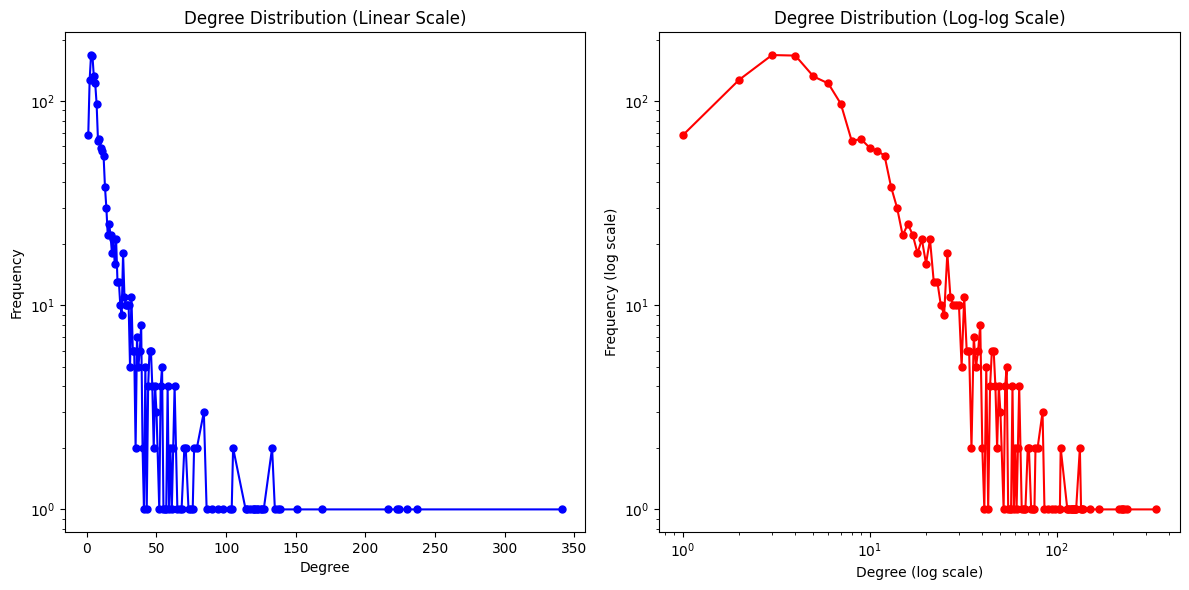

In [9]:
# Your degree sequence and degree count calculation
degree_sequence = sorted([d for n, d in G_noLabel.degree()], reverse=True)
degreeCount = {}
for degree in degree_sequence:
    if degree in degreeCount:
        degreeCount[degree] += 1
    else:
        degreeCount[degree] = 1
degrees, counts = zip(*degreeCount.items())

# Plotting the degree distribution (linear scale)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(degrees, counts, 'bo-', markersize=5)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Linear Scale)')

# Plotting the degree distribution (log-log scale)
plt.subplot(1, 2, 2)
plt.loglog(degrees, counts, 'ro-', markersize=5)
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution (Log-log Scale)')

plt.tight_layout()
plt.show()

## Graph function

In [11]:
#blue --> basic node
#green --> starting gossip nodes
#red --> starting malicious nodes
#orange --> wrong groppis nodes


def initialize_graph(G,random_value,num_nodes_malicious,arr_gossip = [],arr_malicious = []):
    colors = ['blue' if random.random() < random_value else 'green' for _ in range(G.number_of_nodes())]  # Randomly select initial gossip nodes

    if len(arr_gossip) > 0:
        # If num_hub_gossip is greater than 0, select the hub node with the highest degree as the gossip node
        colors = ['blue' for _ in range(G.number_of_nodes())]
        for hub, _ in arr_gossip:
            colors[hub] = 'green'  # Set the color of the hub node to green

    if len(arr_malicious) > 0:
        for node, _ in arr_malicious:
            colors[node] = 'red'
    else:
        malicious_nodes = arr_malicious if len(arr_malicious) > 0 else random.sample(list(range(G.number_of_nodes())), num_nodes_malicious)
        for node in malicious_nodes:
            colors[node] = 'red'

    return colors

def draw_graph_subplot(G, colors, pos, ax, title):
    nx.draw(G, pos=pos, with_labels=False, node_color=colors, node_size=10, width=0.10, ax=ax)
    ax.set_title(title)

    # Create legend manually
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="blue", markersize=10, label=f'Basic nodes ({colors.count("blue")})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="green", markersize=10, label=f'Gossip nodes ({colors.count("green")})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="red", markersize=10, label=f'Starting malicious nodes ({colors.count("red")})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="orange", markersize=10, label=f'Wrong gossip nodes ({colors.count("orange")})')
    ]
    ax.legend(handles=legend_elements, loc='lower left')

def contagion_step(G, colors, threshold, malicious_treshold):
    new_colors = colors.copy()
    for node in G.nodes():
        green = 0
        orange = 0
        if colors[node] == 'blue':
            neighbors = list(G.neighbors(node))
            #count the gossip nodes in the neighbors
            green = sum(colors[n] == 'green' for n in neighbors)
            orange = sum(colors[n] == 'orange' for n in neighbors)
            
            num_infected_neighbors = green+orange
            if num_infected_neighbors >= threshold * len(neighbors):
              #The node receive the gossip wrong or right depending on the majority of the information received
                new_colors[node] = 'green' if green >= orange else 'orange'

        elif colors[node] == 'red':
          neighbors = list(G.neighbors(node))
          
          #count the gossip nodes in the neighbors
          green = sum(colors[n] == 'green' for n in neighbors)
          orange = sum(colors[n] == 'orange' for n in neighbors)

          num_infected_neighbors = green+orange
          if num_infected_neighbors >= malicious_treshold * len(neighbors):
            new_colors[node] = 'orange'
    return new_colors

## Case 0: random gossip node and 7% malicious node with high and low treshold

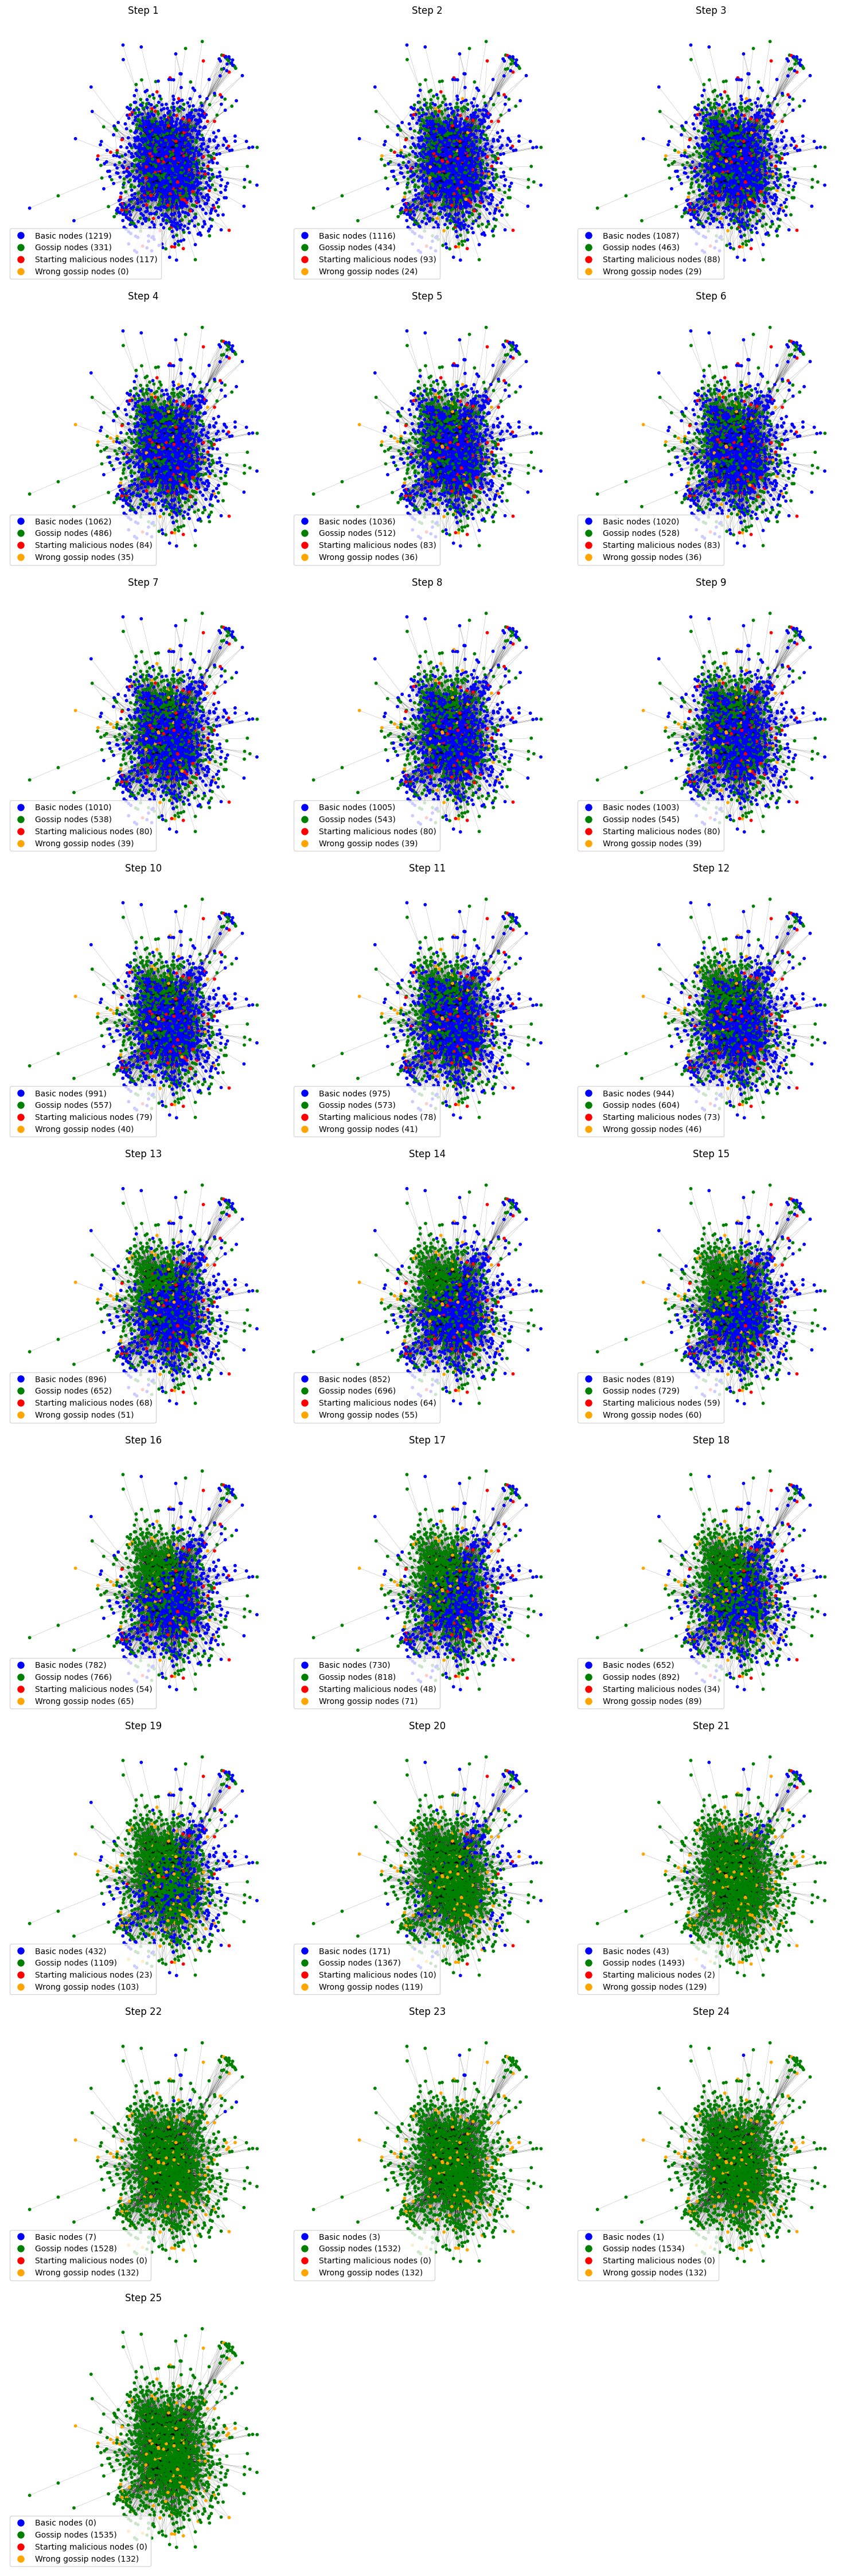

In [17]:
threshold = 0.4
malicious_threshold = 0.3

#Graph - % for random gossip node - #of malicious nodes - array of node to set not random contagious
colors = initialize_graph(G_noLabel,0.80,round( (G_noLabel.number_of_nodes()*7)/100 ))

pos = nx.spring_layout(G_noLabel,scale=100)  # Fix the position of the nodes

# Track the contagion process
contagion_steps = [colors]

while 'blue' in colors:
    new_colors = contagion_step(G_noLabel, colors, threshold, malicious_threshold)
    if new_colors == colors:
        break
    colors = new_colors
    contagion_steps.append(colors)

# Plot all steps in subplots
num_steps = len(contagion_steps)
cols = 3
rows = (num_steps // cols) + (1 if num_steps % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, step_colors in enumerate(contagion_steps):
    draw_graph_subplot(G_noLabel, step_colors, pos, axes[i], f'Step {i+1}')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Case 1: random gossip node (threshold 0.20 to be gossip) and 7% malicious node.

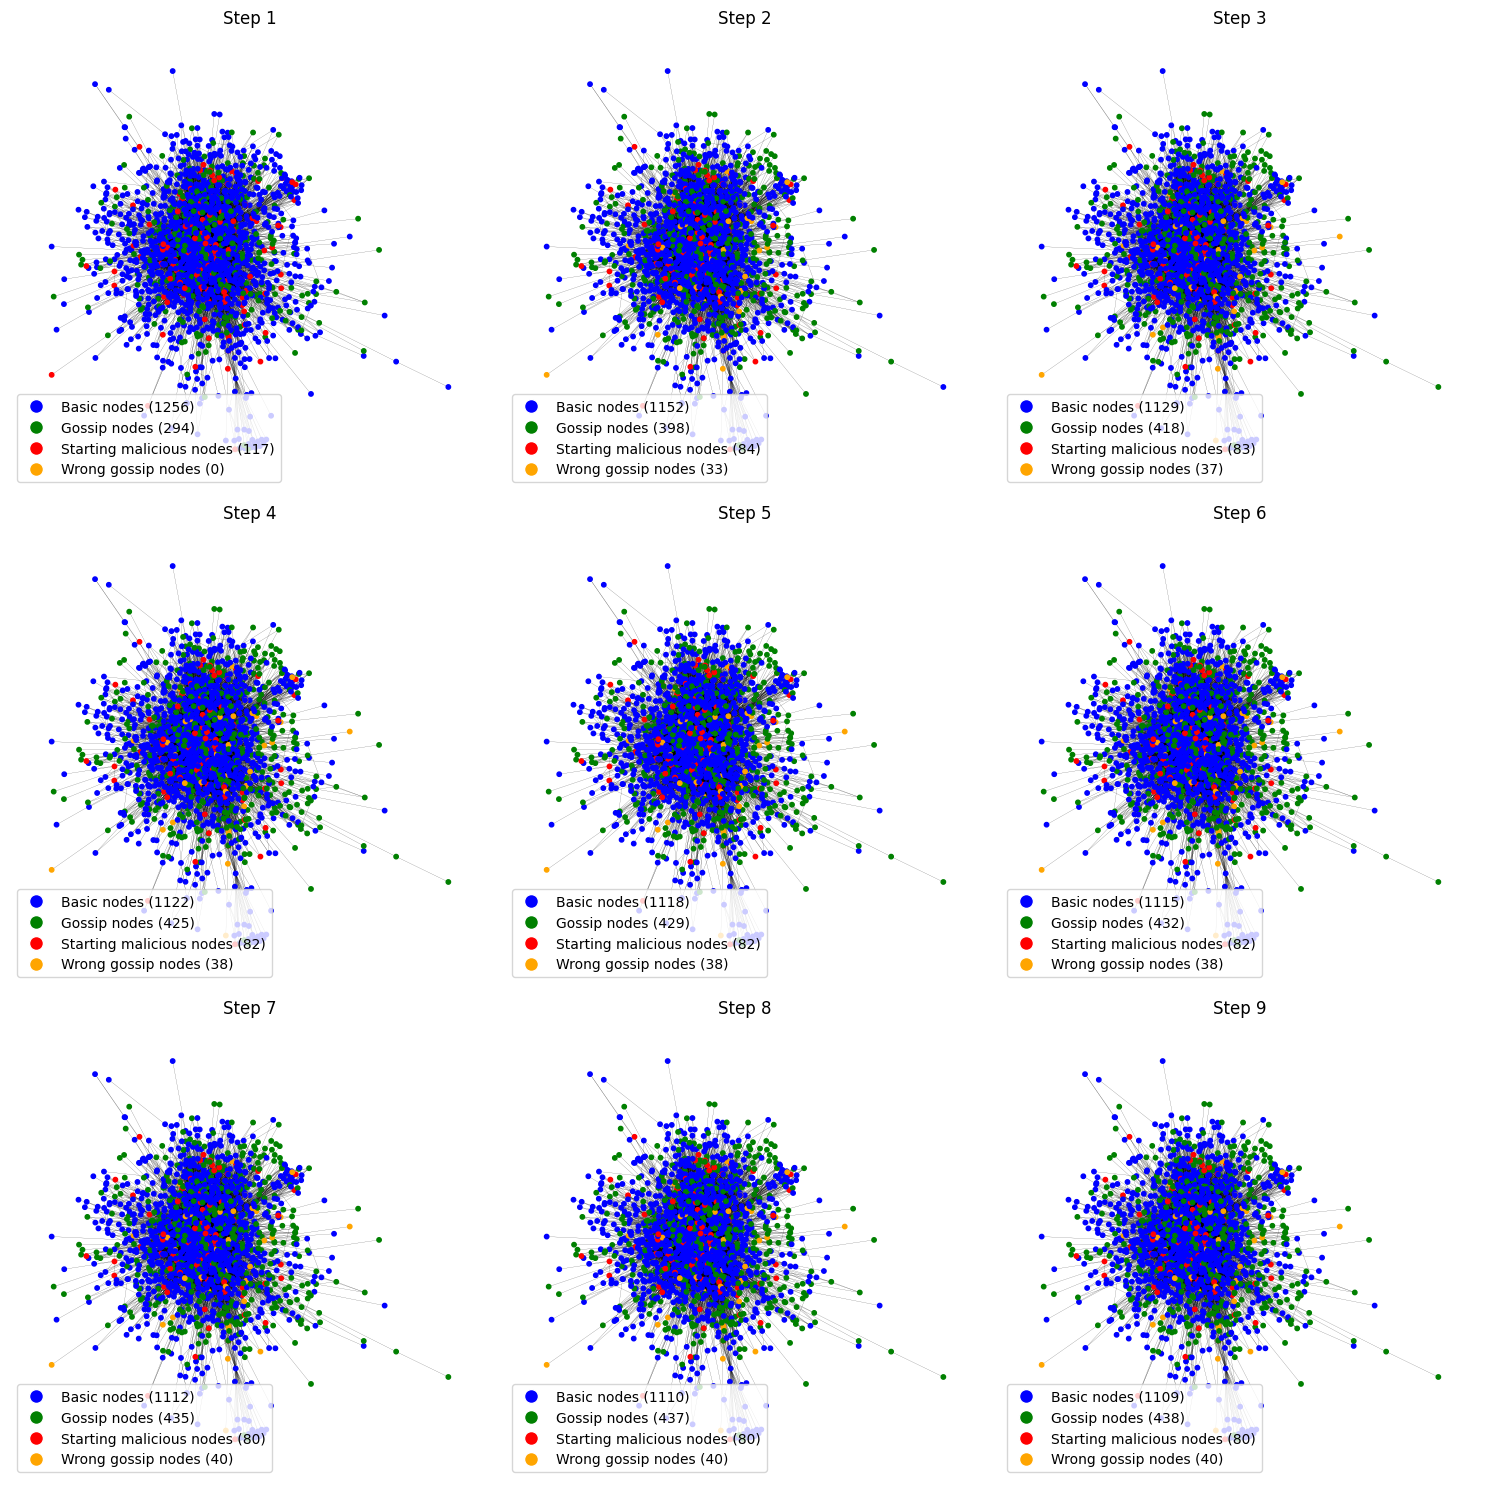

In [65]:
threshold = 0.5
malicious_threshold = 0.3

#Graph - % for random gossip node - #of malicious nodes - array of node to set not random contagious
colors = initialize_graph(G_noLabel,0.8,round( (G_noLabel.number_of_nodes()*7)/100 ))

pos = nx.spring_layout(G_noLabel,scale=100)  # Fix the position of the nodes

# Track the contagion process
contagion_steps = [colors]

while 'blue' in colors:
    new_colors = contagion_step(G_noLabel, colors, threshold, malicious_threshold)
    if new_colors == colors:
        break
    colors = new_colors
    contagion_steps.append(colors)

# Plot all steps in subplots
num_steps = len(contagion_steps)
cols = 3
rows = (num_steps // cols) + (1 if num_steps % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, step_colors in enumerate(contagion_steps):
    draw_graph_subplot(G_noLabel, step_colors, pos, axes[i], f'Step {i+1}')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Case 2: random gossip node (threshold 0.30 to be gossip) and 10% malicious node.

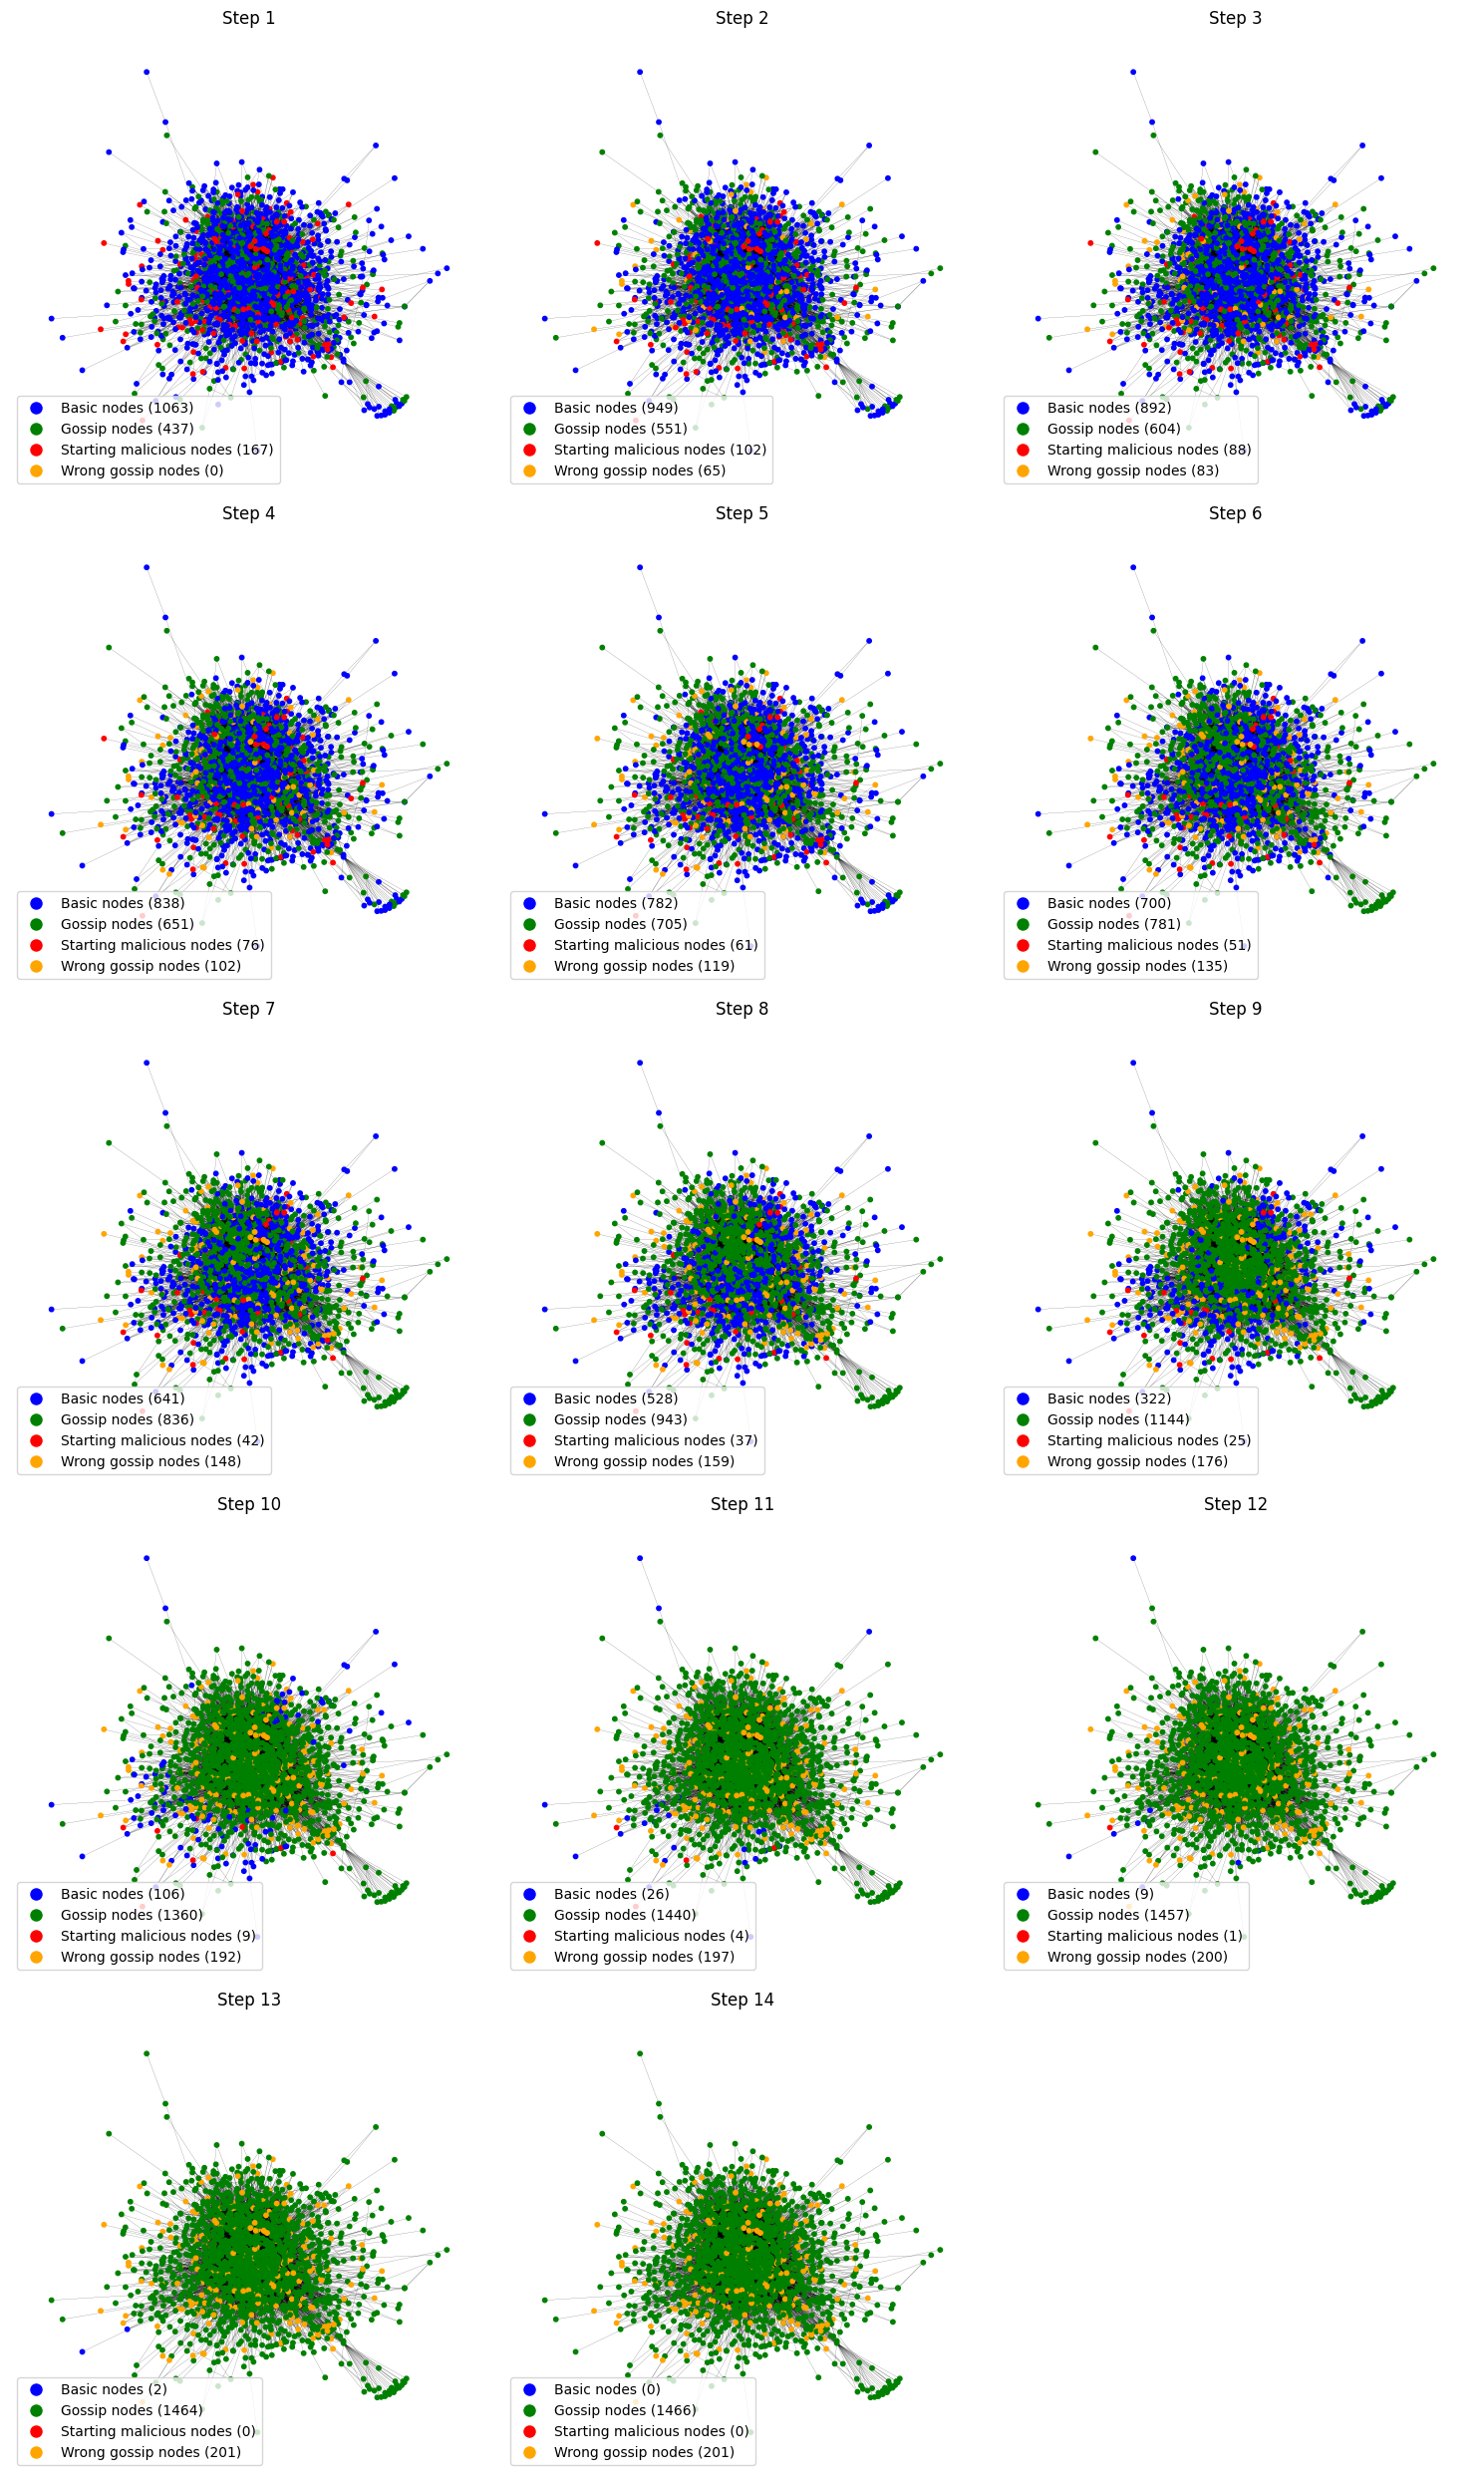

In [18]:
threshold = 0.5
malicious_threshold = 0.3

#Graph - % for random gossip node - #of malicious nodes - array of node to set not random contagious
colors = initialize_graph(G_noLabel,0.70,round( (G_noLabel.number_of_nodes()*10)/100 ))

pos = nx.spring_layout(G_noLabel,scale=100)  # Fix the position of the nodes

# Track the contagion process
contagion_steps = [colors]

while 'blue' in colors:
    new_colors = contagion_step(G_noLabel, colors, threshold, malicious_threshold)
    if new_colors == colors:
        break
    colors = new_colors
    contagion_steps.append(colors)

# Plot all steps in subplots
num_steps = len(contagion_steps)
cols = 3
rows = (num_steps // cols) + (1 if num_steps % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, step_colors in enumerate(contagion_steps):
    draw_graph_subplot(G_noLabel, step_colors, pos, axes[i], f'Step {i+1}')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Case 3: selected gossip node (hubs) and 10% malicious node

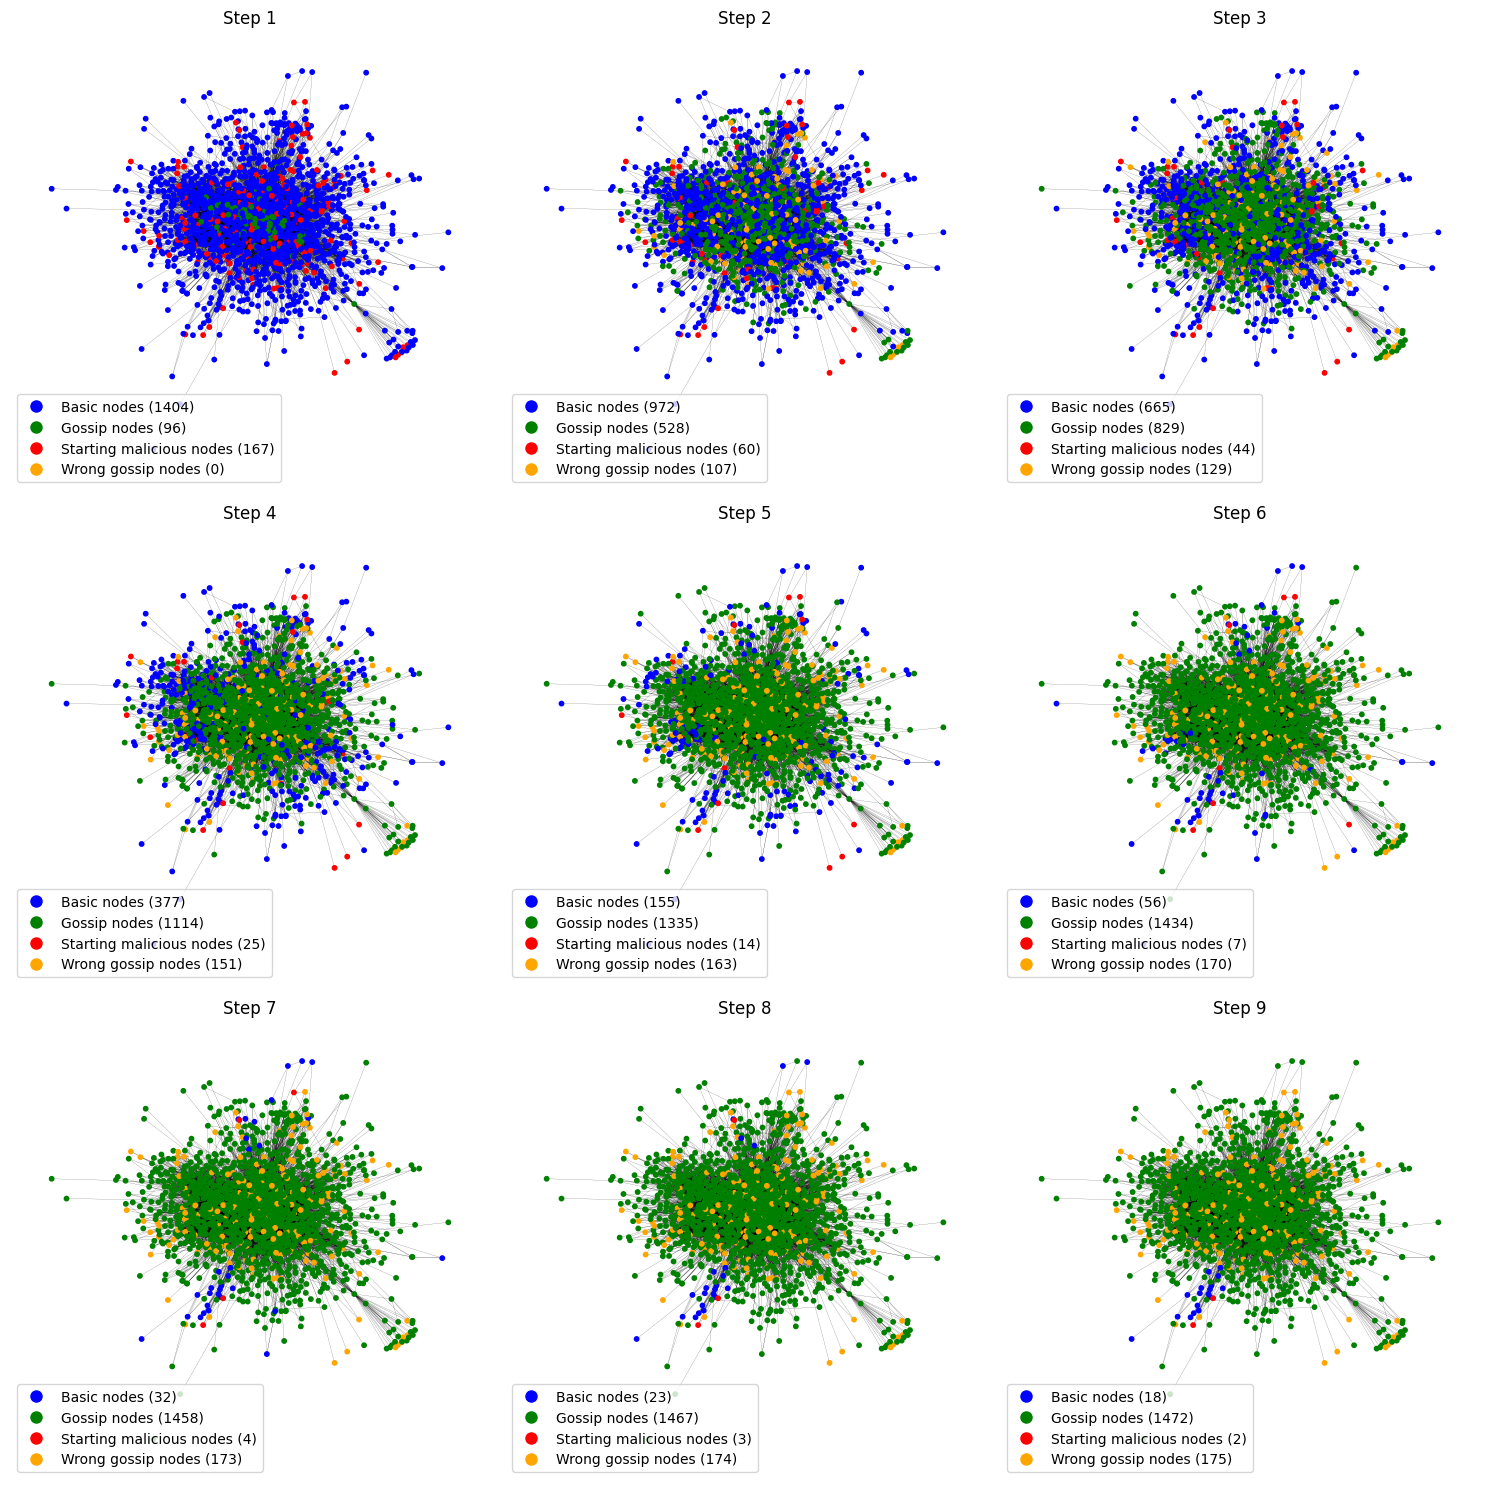

In [17]:
threshold = 0.5
malicious_threshold = 0.3

hubs = sorted(G_noLabel.degree, key=lambda x: x[1], reverse=True)[:100]

colors = initialize_graph(G_noLabel,0,round( (G_noLabel.number_of_nodes()*10)/100 ),hubs)

pos = nx.spring_layout(G_noLabel,scale=100)  # Fix the position of the nodes

# Track the contagion process
contagion_steps = [colors]

while 'blue' in colors:
    new_colors = contagion_step(G_noLabel, colors, threshold, malicious_threshold)
    if new_colors == colors:
        break
    colors = new_colors
    contagion_steps.append(colors)

# Plot all steps in subplots
num_steps = len(contagion_steps)
cols = 3
rows = (num_steps // cols) + (1 if num_steps % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, step_colors in enumerate(contagion_steps):
    draw_graph_subplot(G_noLabel, step_colors, pos, axes[i], f'Step {i+1}')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Case 4: selected gossip node random (threshold 0.30 to be gossip) and hubs as malicious node

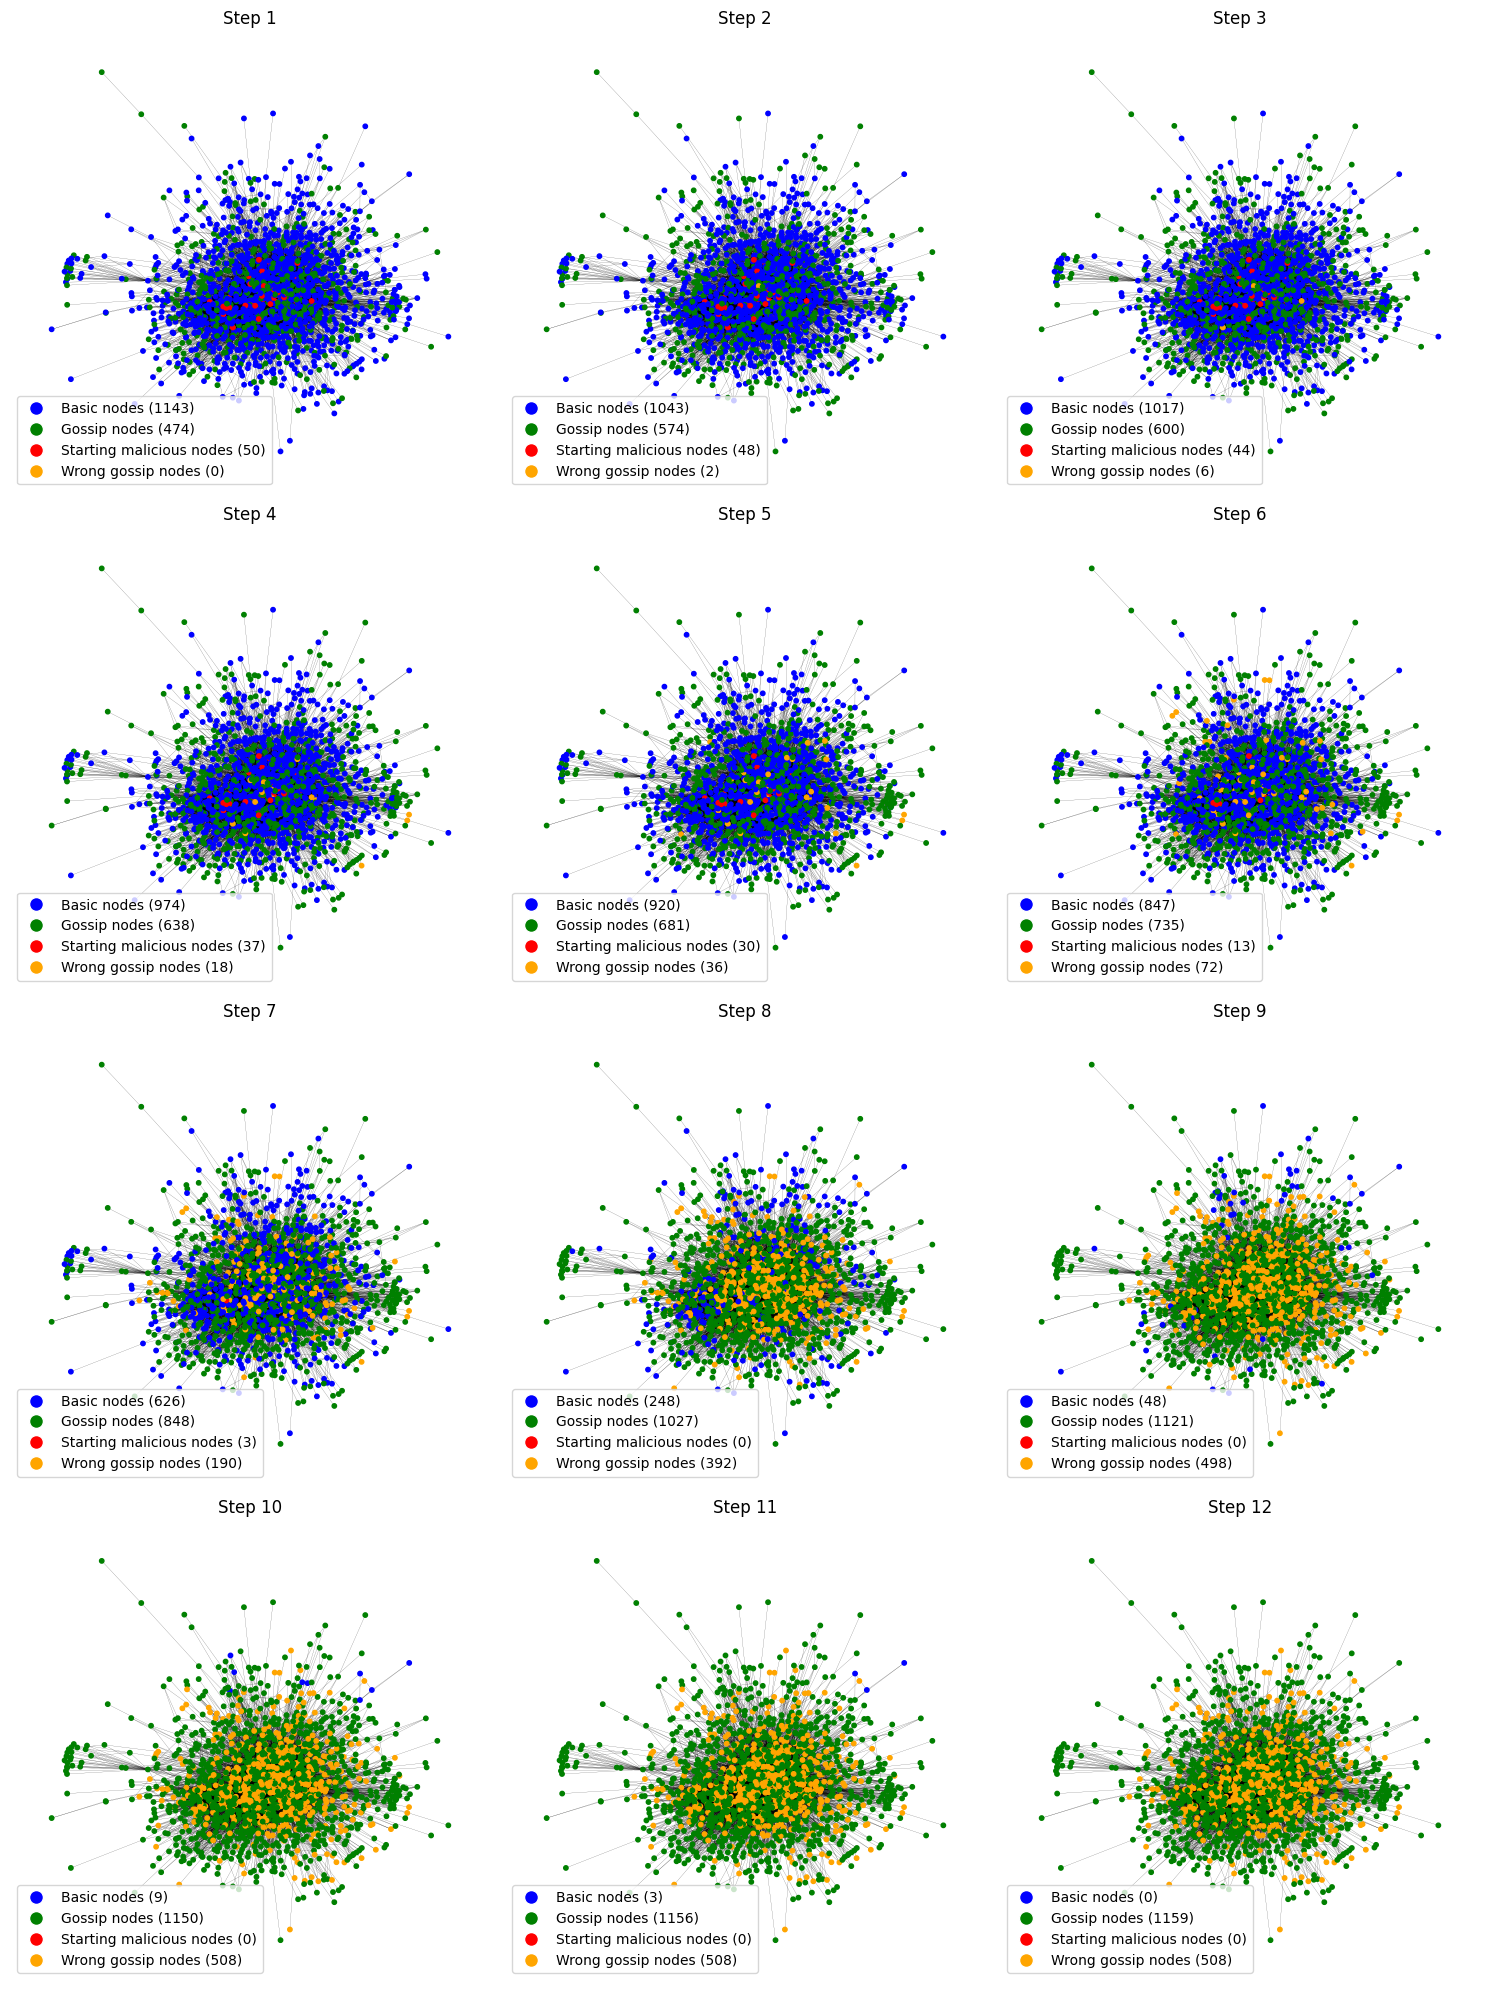

In [68]:
threshold = 0.5
malicious_threshold = 0.3

hubs = sorted(G_noLabel.degree, key=lambda x: x[1], reverse=True)[:50]

colors = initialize_graph(G_noLabel,0.70,round( (G_noLabel.number_of_nodes()*10)/100 ),arr_malicious=hubs)

pos = nx.spring_layout(G_noLabel,scale=100)  # Fix the position of the nodes

# Track the contagion process
contagion_steps = [colors]

while 'blue' in colors:
    new_colors = contagion_step(G_noLabel, colors, threshold, malicious_threshold)
    if new_colors == colors:
        break
    colors = new_colors
    contagion_steps.append(colors)

# Plot all steps in subplots
num_steps = len(contagion_steps)
cols = 3
rows = (num_steps // cols) + (1 if num_steps % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, step_colors in enumerate(contagion_steps):
    draw_graph_subplot(G_noLabel, step_colors, pos, axes[i], f'Step {i+1}')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Case 5: selected gossip node random and highest betweenness as malicious node

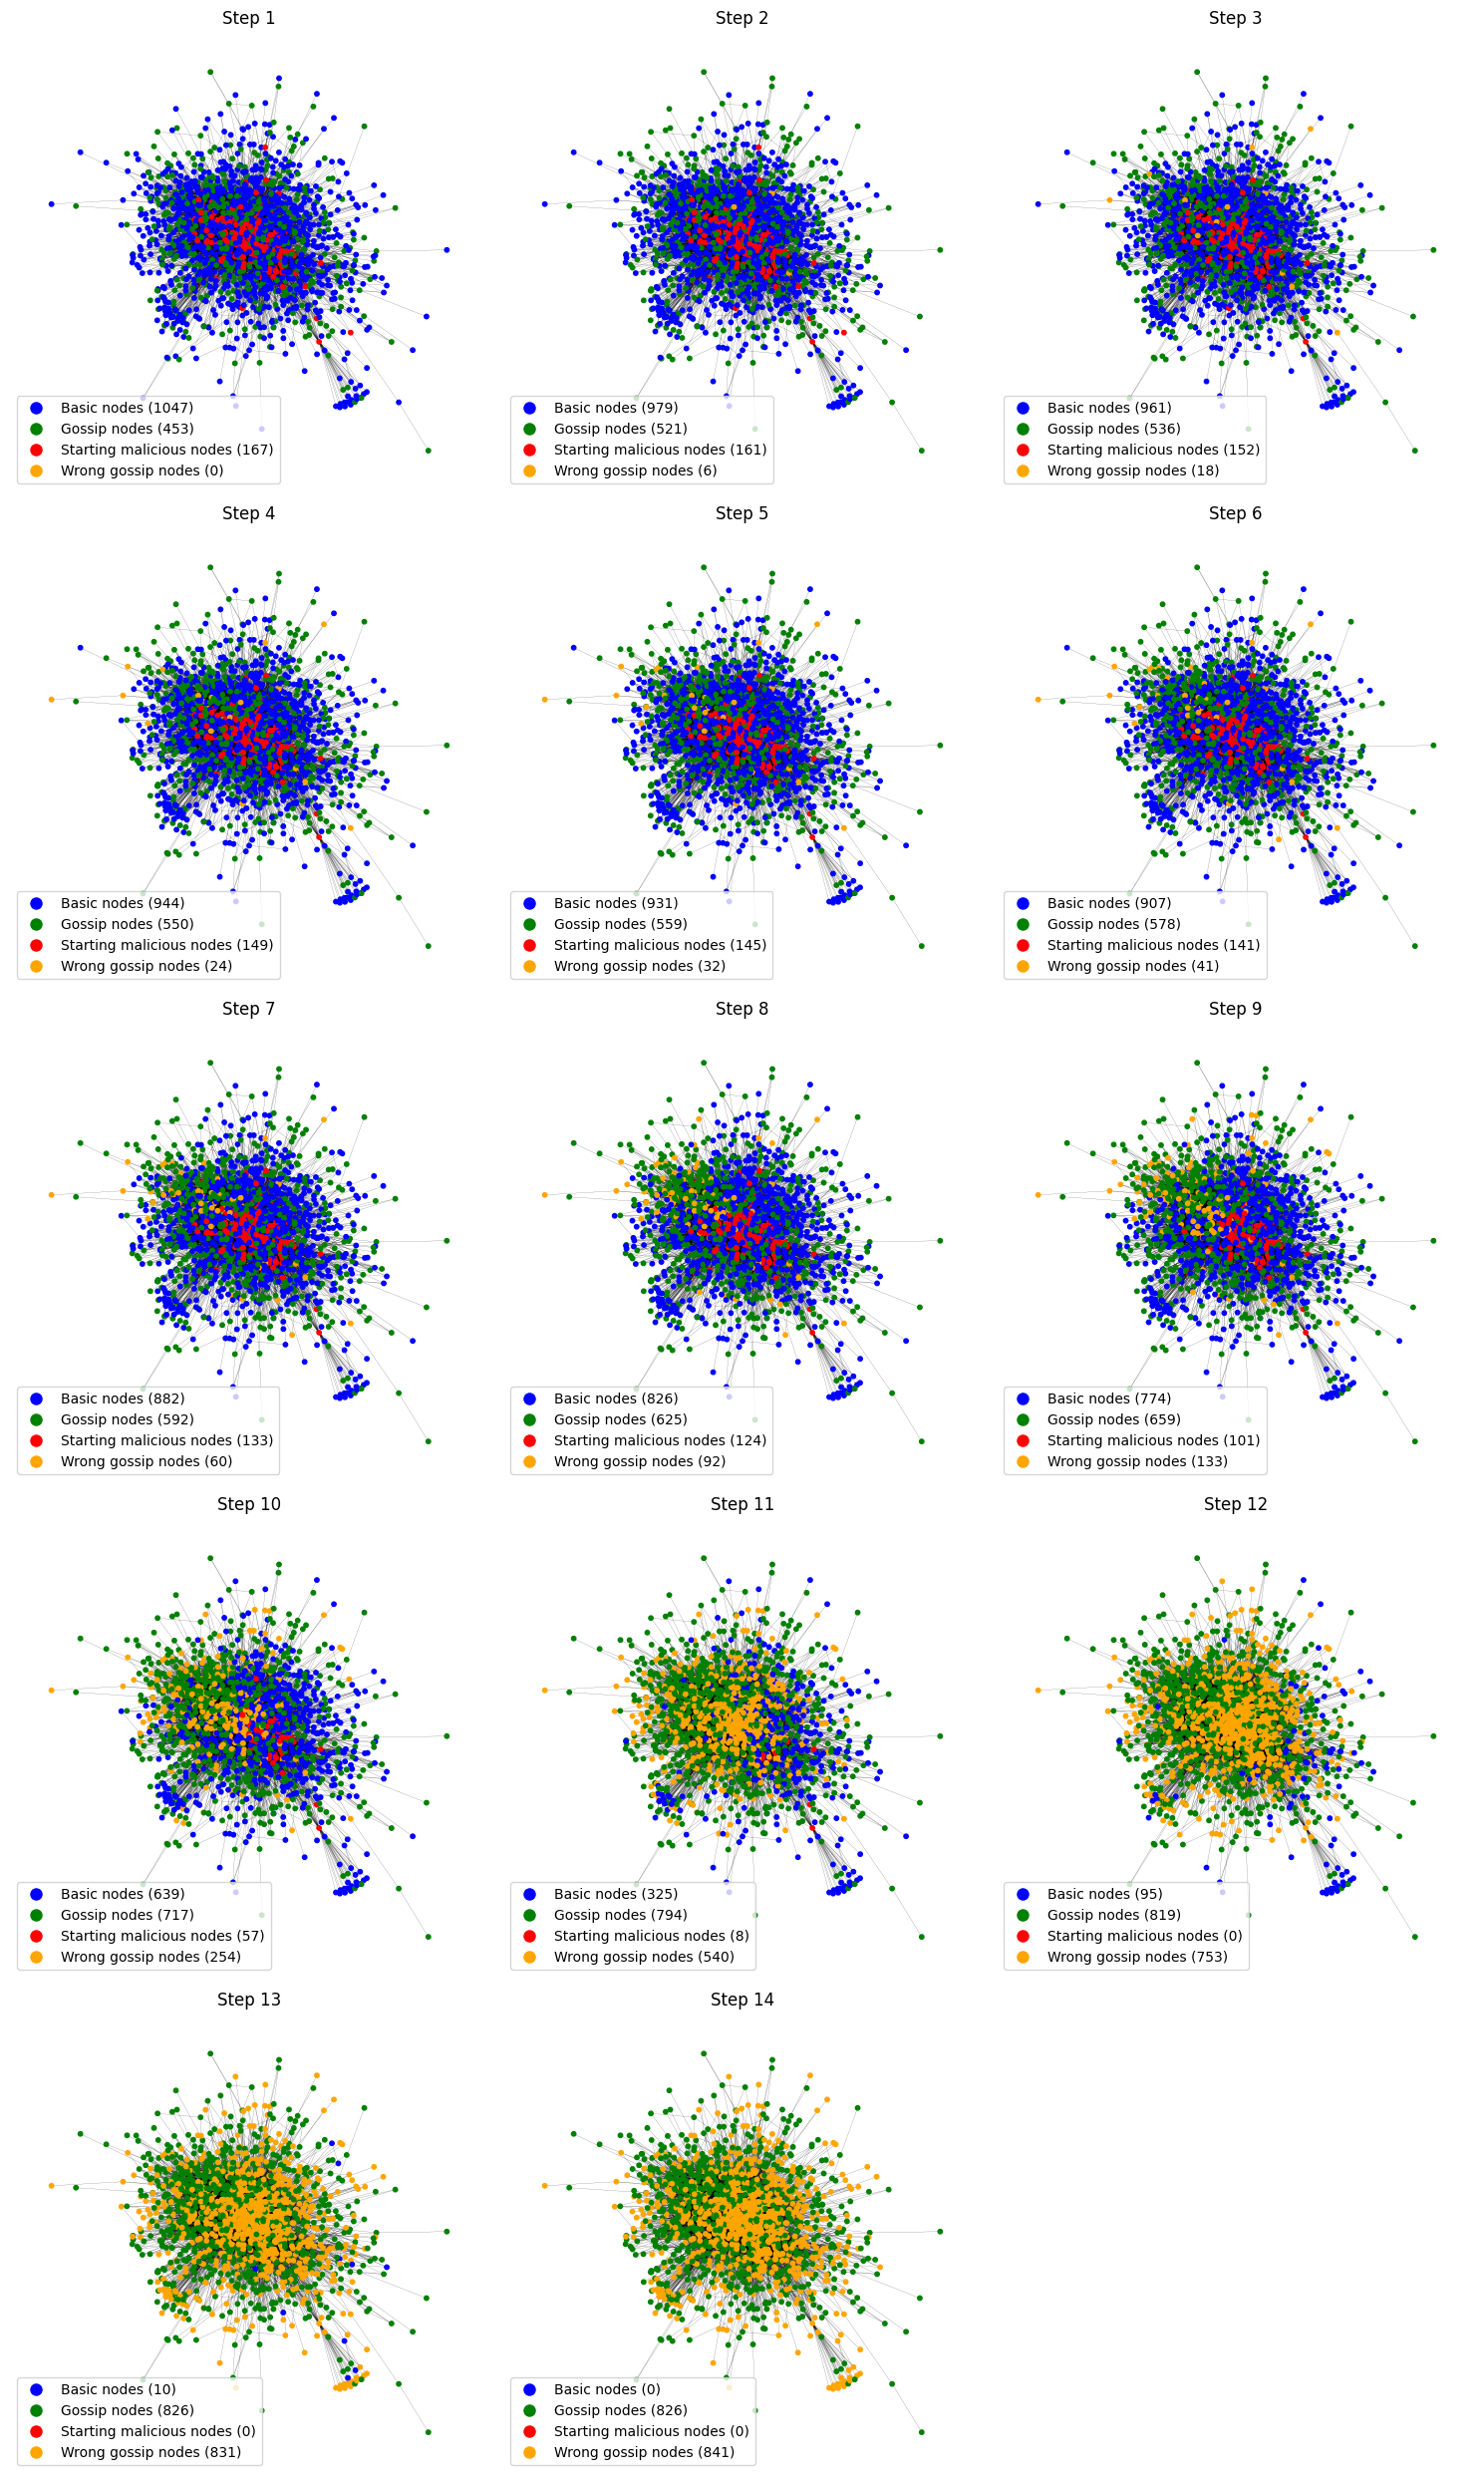

In [15]:
threshold = 0.5
malicious_threshold = 0.3

# Calculate betweenness centrality for all nodes
betweenness = nx.betweenness_centrality(G_noLabel)
# Sort nodes by betweenness centrality in descending order
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)
# Select 10% of the nodes with the highest betweenness centrality
num_malicious = round(len(sorted_betweenness)/10)
malicious_nodes = sorted_betweenness[:num_malicious]

colors = initialize_graph(G_noLabel, 0.70, num_malicious, arr_malicious=malicious_nodes)

pos = nx.spring_layout(G_noLabel, scale=100)  # Fix the position of the nodes

# Track the contagion process
contagion_steps = [colors]

while 'blue' in colors:
    new_colors = contagion_step(G_noLabel, colors, threshold, malicious_threshold)
    if new_colors == colors:
        break
    colors = new_colors
    contagion_steps.append(colors)

# Plot all steps in subplots
num_steps = len(contagion_steps)
cols = 3
rows = (num_steps // cols) + (1 if num_steps % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, step_colors in enumerate(contagion_steps):
    draw_graph_subplot(G_noLabel, step_colors, pos, axes[i], f'Step {i+1}')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()